# Import Statements

In [21]:
import pickle
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
import requests
from collections import defaultdict

import re
from datetime import datetime
import glob

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

# Necessary imports
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


pd.set_option('display.max_columns', 500)

# Functions

In [2]:
def load_pickle(file_location):
    with open(file_location, "rb") as picklefile:
        df = pickle.load(picklefile)
    return(df)

# Clean Data

In [3]:
df = load_pickle("all_midtown_data.pkl")

In [4]:
# Remove Building Type column. They are all Condos
df = df.drop("Building Type", axis=1)

# Sort values by date sold
df = df.sort_values(by = 'sold_date_dt', ascending = False)

# Drop duplicate rows
#df_no_dup = df.drop_duplicates(subset = 'full_name', keep = 'first').reset_index(drop = True)
#print("1. Duplicates Removed")

# Add season
df['sold_season'] = (df['sold_date_dt']
                     .dt
                     .month
                     .map({1 : 'Winter', 
                           2 : 'Winter',
                           3 : 'Spring',
                           4 : 'Spring',
                           5 : 'Spring',
                           6 : 'Summer',
                           7 : 'Summer',
                           8 : 'Summer',
                           9 : 'Fall',
                           10 : 'Fall',
                           11 : 'Fall',
                           12 : 'Winter'}))
print("2. Season Added")

# Add days on market column, and convert datetime timedelta to float
df['days_on_market'] = df['sold_date_dt'] - df['Listed']
df['days_on_market'] = (df['days_on_market']/np.timedelta64(1, 'D'))
print("3. Days on Market Added")

# Fill to indicate Studio
df['beds'] = df['beds'].fillna(0)
print("4. Filled Beds to indicate Studio")

### Fixing rows where there is no condo ###
# Find where apt = NaN
df_apt_na = df[df['apt_floor'].isna()]

# Fill Apt nulls, move bldg address to correct place, and delete bldg name
for index, row in df_apt_na.iterrows():
    #print(row['apt_floor'])
    #print(np.isnan(row['apt_floor']))
    try:
        if np.isnan(row['apt_floor']):
            df.loc[index, 'apt_floor'] = int(re.findall('\d+', row['bldg_addr'])[0]) # assign value in full dataframe
            df.loc[index, 'bldg_addr'] = df.loc[index]['bldg_name'] # move building address over to correct column
            df.loc[index, 'bldg_name'] = np.nan # clears building name
            #print(index)
        else:
            continue
    except:
        continue
print("5. Apt Nulls Filled")

# Rename Columns
df = df.rename(columns = {"Listed": "listed", 
                 "Days on Market": "days_on_market", 
                 "Neighborhood": "neighborhood", 
                 "Monthly Common Charges": "monthly_common_charges", 
                 "Monthly Real Estate Taxes": "monthly_real_estate_taxes", 
                 "Minimum Down Payment": "minimum_down_payment", 
                 "Doorman": "doorman", 
                 "Last Price Change": "last_price_change"})
print("6. Renamed Columns")

2. Season Added
3. Days on Market Added
4. Filled Beds to indicate Studio
5. Apt Nulls Filled
6. Renamed Columns


In [9]:
#df_clean['year'] = df_clean['sold_date_dt'].apply(lambda x: x.strftime('%Y'))
df['year'] = df['sold_date_dt'].apply(lambda x: x.strftime('%Y'))
#df.head()

In [10]:
df.shape

(22945, 25)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22945 entries, 0 to 14377
Data columns (total 25 columns):
full_name                    22945 non-null object
bldg_name                    19449 non-null object
bldg_addr                    22945 non-null object
apt_floor                    22916 non-null float64
bldg_rating                  22124 non-null float64
sold_date                    22945 non-null object
sold_date_dt                 22945 non-null datetime64[ns]
sold_price                   22945 non-null float64
price_per_sqft               11885 non-null float64
square_feet                  11885 non-null float64
bed_and_bath                 22945 non-null object
beds                         22945 non-null float64
baths                        22908 non-null float64
url                          22945 non-null object
listed                       12657 non-null datetime64[ns]
days_on_market               12657 non-null object
neighborhood                 12657 non-null object
m

# EDA

In [12]:
target = ['sold_price']
cont = ['bldg_rating', 
        'apt_floor',
        'square_feet', 
        'beds', 
        'baths', 
        'monthly_common_charges', 
        'monthly_real_estate_taxes']
cat = ['sold_season', 'neighborhood', 'year']
model_columns = cont + cat + target

In [13]:
smaller_df = df.loc[:, model_columns]
#smaller_df.shape
smaller_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22945 entries, 0 to 14377
Data columns (total 11 columns):
bldg_rating                  22124 non-null float64
apt_floor                    22916 non-null float64
square_feet                  11885 non-null float64
beds                         22945 non-null float64
baths                        22908 non-null float64
monthly_common_charges       12529 non-null float64
monthly_real_estate_taxes    12102 non-null float64
sold_season                  22945 non-null object
neighborhood                 12657 non-null object
year                         22945 non-null object
sold_price                   22945 non-null float64
dtypes: float64(8), object(3)
memory usage: 2.1+ MB


In [14]:
# Drop NAs
smaller_df = smaller_df.dropna().reset_index(drop = True)
# smaller_df.head()

In [15]:
smaller_df.describe()

,bldg_rating,apt_floor,square_feet,beds,baths,monthly_common_charges,monthly_real_estate_taxes,sold_price
count,9213.000000,9213.000000,9213.000000,9213.000000,9213.000000,9213.000000,9213.000000,9.213000e+03
mean,76.403560,172.635841,949.395962,1.216325,1.503256,1118.170086,936.144687,1.519628e+06
std,10.546259,644.239001,386.183235,0.685108,0.578312,1187.605880,1259.686924,1.272554e+06
min,44.000000,1.000000,285.000000,0.000000,1.000000,216.000000,101.000000,1.715180e+05
25%,70.000000,7.000000,670.000000,1.000000,1.000000,678.000000,530.000000,8.350000e+05
50%,78.000000,17.000000,868.000000,1.000000,1.000000,918.000000,774.000000,1.199000e+06
75%,84.000000,33.000000,1179.000000,2.000000,2.000000,1340.000000,1146.000000,1.750000e+06
max,99.000000,6304.000000,3895.000000,4.000000,5.000000,64560.000000,75980.000000,2.350000e+07


In [16]:
smaller_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9213 entries, 0 to 9212
Data columns (total 11 columns):
bldg_rating                  9213 non-null float64
apt_floor                    9213 non-null float64
square_feet                  9213 non-null float64
beds                         9213 non-null float64
baths                        9213 non-null float64
monthly_common_charges       9213 non-null float64
monthly_real_estate_taxes    9213 non-null float64
sold_season                  9213 non-null object
neighborhood                 9213 non-null object
year                         9213 non-null object
sold_price                   9213 non-null float64
dtypes: float64(8), object(3)
memory usage: 791.9+ KB


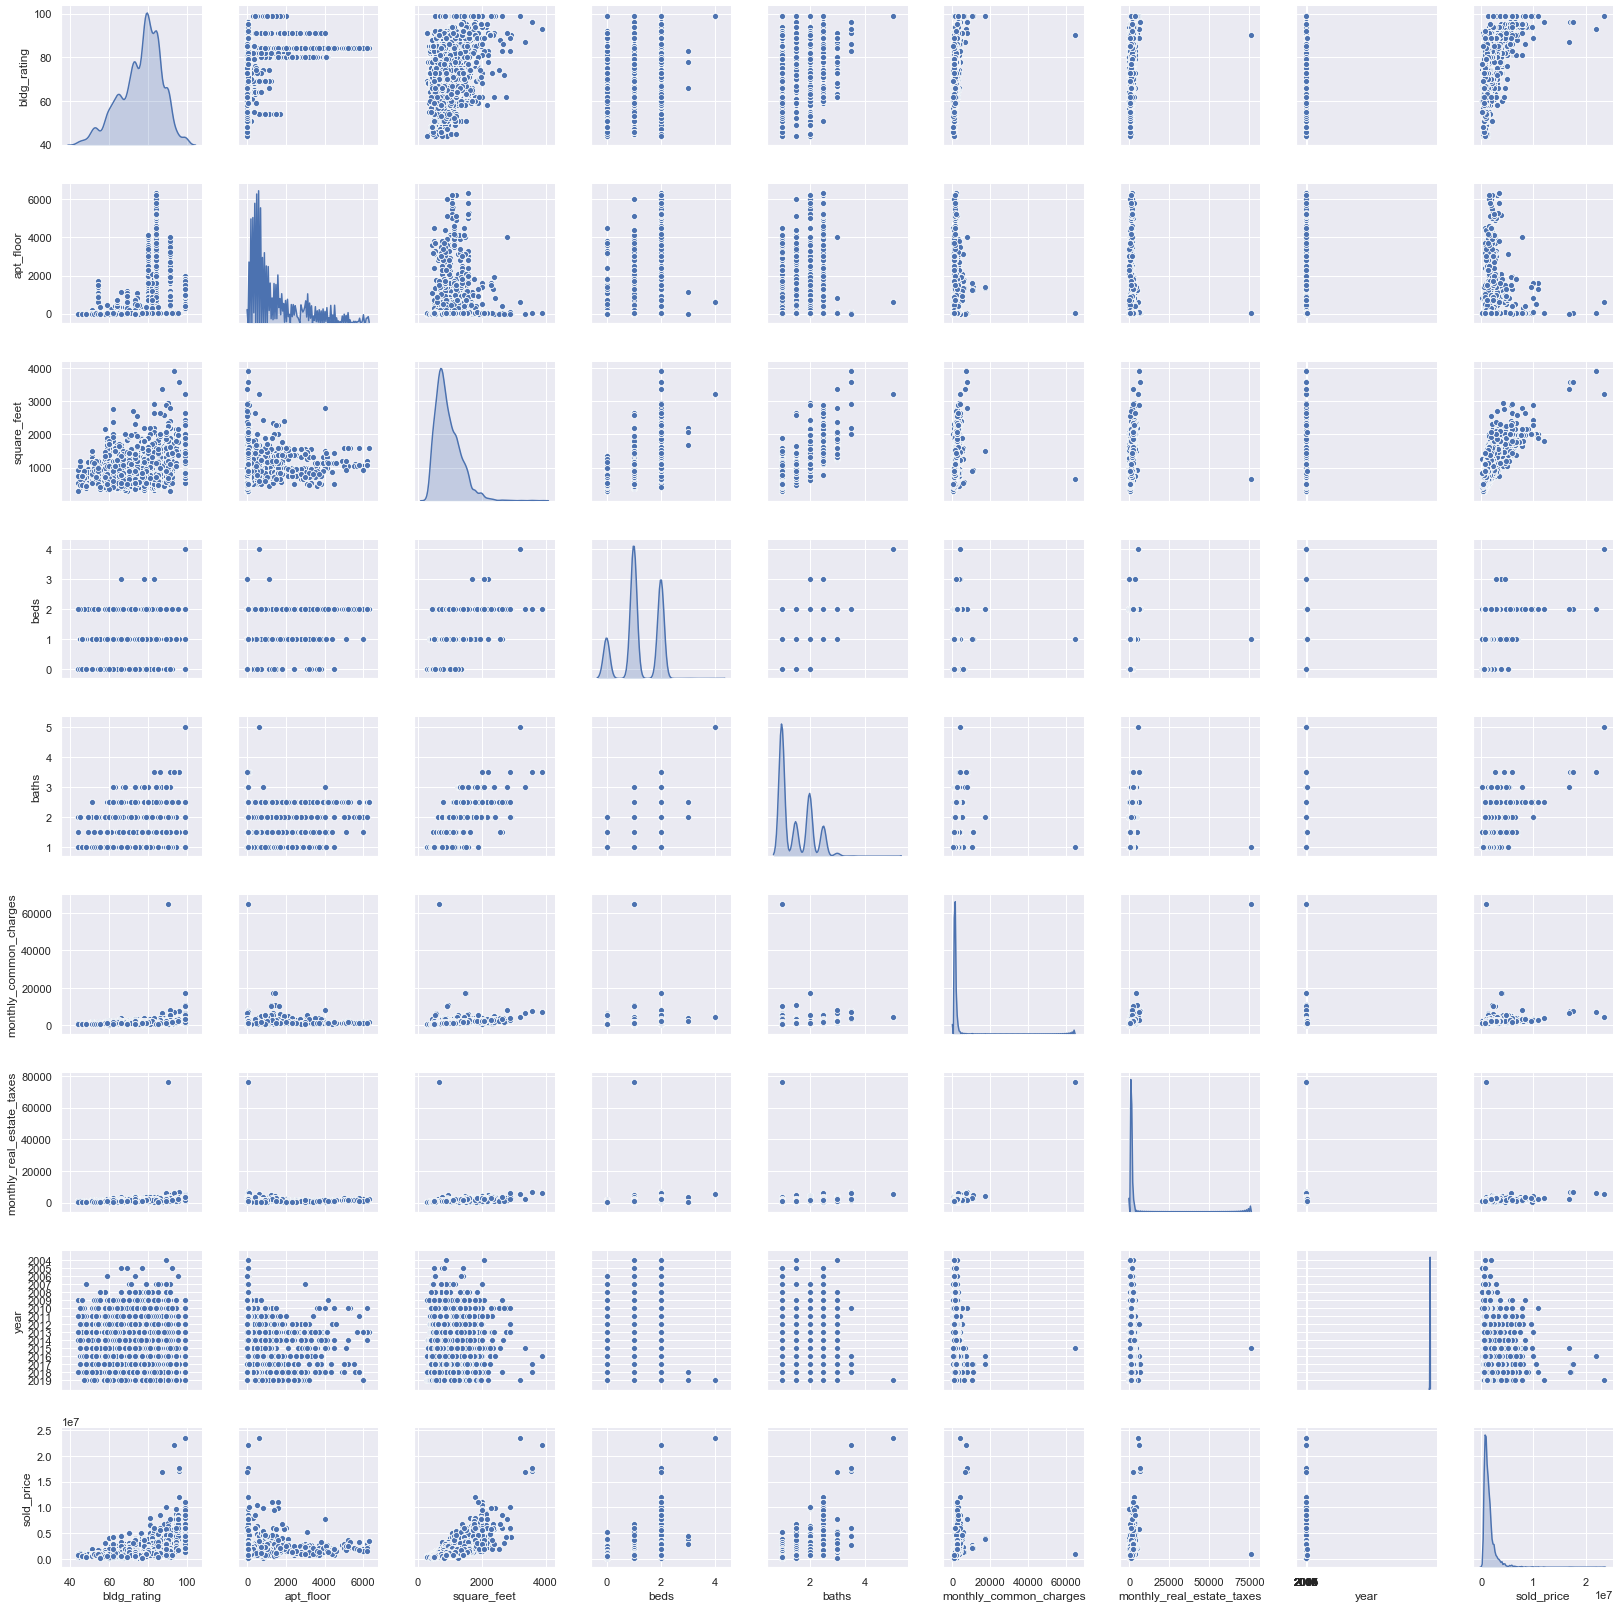

In [17]:
sns.pairplot(smaller_df, diag_kind='kde')

In [18]:
smaller_df.corr()

,bldg_rating,apt_floor,square_feet,beds,baths,monthly_common_charges,monthly_real_estate_taxes,sold_price
bldg_rating,1.000000,0.168424,0.319553,0.140756,0.293470,0.229591,0.164236,0.397080
apt_floor,0.168424,1.000000,0.096148,0.060561,0.114580,0.090550,0.034372,0.124835
square_feet,0.319553,0.096148,1.000000,0.759236,0.842308,0.422368,0.327033,0.775133
beds,0.140756,0.060561,0.759236,1.000000,0.770582,0.282847,0.226872,0.492474
baths,0.293470,0.114580,0.842308,0.770582,1.000000,0.342631,0.264079,0.622095
monthly_common_charges,0.229591,0.090550,0.422368,0.282847,0.342631,1.000000,0.887635,0.414322
monthly_real_estate_taxes,0.164236,0.034372,0.327033,0.226872,0.264079,0.887635,1.000000,0.322614
sold_price,0.397080,0.124835,0.775133,0.492474,0.622095,0.414322,0.322614,1.000000


In [19]:
#sns.distplot(smaller_df['sold_price'])
#smaller_df.head()

In [20]:
# Get Dummies
df_model = pd.get_dummies(smaller_df)

# Remove large outliers from sold

df_model.head()

,bldg_rating,apt_floor,square_feet,beds,baths,monthly_common_charges,monthly_real_estate_taxes,sold_price,sold_season_Fall,sold_season_Spring,sold_season_Summer,sold_season_Winter,neighborhood_Beekman/Sutton Place,neighborhood_Midtown East,neighborhood_Midtown West,neighborhood_Murray Hill,neighborhood_Turtle Bay/United Nations,year_2004,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019
0,78.0,25.0,650.0,1.0,1.0,814.0,948.0,799000.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,78.0,25.0,650.0,1.0,1.0,814.0,948.0,799000.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,78.0,25.0,650.0,1.0,1.0,814.0,948.0,799000.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,79.0,21.0,690.0,1.0,1.0,689.0,1315.0,1085000.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,79.0,21.0,690.0,1.0,1.0,689.0,1315.0,1085000.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


# Simple Model - 1 Variable

In [22]:
#sns.distplot(df_model['sold_price'][df_model['sold_price'] <10000000])
#plt.scatter(df_model['sold_price'])

In [23]:
#target = ['sold_price']
#cont = ['bldg_rating', 
#        'apt_floor',
#        'square_feet', 
#        'beds', 
#        'baths', 
#        'monthly_common_charges', 
#        'monthly_real_estate_taxes']
#cat = ['sold_season', 'neighborhood']
#model_columns = cont + cat + target

# Define X values and y values
X = df_model.drop('sold_price', axis = 1)
y = df_model['sold_price']

In [24]:
# hold out 20% of the data for final testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10)

In [25]:
X_train.shape

(7370, 32)

In [26]:
X_test.shape

(1843, 32)

In [27]:
column_1 = ['square_feet']
one_col_model = LinearRegression()
one_col_model.fit(X_train.loc[:, column_1], y_train)
one_col_model.score(X_train.loc[:, column_1], y_train)
#one_col_model.coef_, one_col_model.intercept_

0.5975542019440261

In [28]:
one_col_model.score(X_test.loc[:, column_1],y_test)

0.6176491226090489

# Comparing Simple Models

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [30]:
# Models

lm = LinearRegression()
lm_reg = Ridge(alpha = 1)

kf = KFold(n_splits=5, shuffle=True, random_state = 1001)

In [33]:
# Linear Regression
np.mean(cross_val_score(lm, X_train, y_train, # estimator, features, target
                cv=kf, # number of folds 
                scoring='r2')) # scoring metric

0.5540313849625313

In [34]:
# Ridge Regression
np.mean(cross_val_score(lm_reg, X_train, y_train, # estimator, features, target
                cv=kf, # number of folds 
                scoring='r2')) # scoring metric

0.5544096543042181

In [35]:
# Linear Regression. Compare Train and Test
lm.fit(X_train, y_train)
print("Train Score: ", lm.score(X_train, y_train))
print("Test Score: ", lm.score(X_test, y_test))

Train Score:  0.6717220971052916
Test Score:  0.6641355562183885


In [36]:
# Ridge Regression. Compare Train and Test
lm_reg.fit(X_train, y_train)
print("Train Score: ", lm_reg.score(X_train, y_train))
print("Test Score: ", lm_reg.score(X_test, y_test))

Train Score:  0.6716727722841707
Test Score:  0.6648348067920592


# Ridge Regression with Standard Scaler

In [37]:
X_train.head()

,bldg_rating,apt_floor,square_feet,beds,baths,monthly_common_charges,monthly_real_estate_taxes,sold_season_Fall,sold_season_Spring,sold_season_Summer,sold_season_Winter,neighborhood_Beekman/Sutton Place,neighborhood_Midtown East,neighborhood_Midtown West,neighborhood_Murray Hill,neighborhood_Turtle Bay/United Nations,year_2004,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019
636,65.0,14.0,590.0,0.0,1.0,819.0,677.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
824,62.0,10.0,1353.0,0.0,1.0,1665.0,1657.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5010,82.0,50.0,812.0,1.0,1.5,1071.0,737.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
6987,74.0,5.0,1267.0,2.0,2.5,1728.0,809.0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7068,79.0,20.0,846.0,1.0,1.0,930.0,406.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [38]:
# Scale Training data and Transform testing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [40]:
# Run Cross Validation on Ridge Regression with scaled features. It is similar to simple models
np.mean(cross_val_score(lm_reg, X_train_scaled, y_train, cv=kf, scoring = 'r2'))

0.5540381094918689

In [39]:
# Ridge Regression
lm_reg = Ridge(alpha=1)
lm_reg.fit(X_train_scaled, y_train)
print(lm_reg.score(X_train_scaled, y_train))
print(lm_reg.score(X_test_scaled, y_test))

0.671722026641166
0.6641761505020942


In [45]:
from sklearn.linear_model import LassoCV
lasso_model = LassoCV()
#lasso_model_2 = Lasso(alpha = 100)
#lasso_model_3 = Lasso(alpha = 1000)
lasso_model.fit(X_train_scaled, y_train)
print("Trained Score: ", lasso_model.score(X_train_scaled, y_train))
print("Test Score: ", lasso_model.score(X_test_scaled, y_test))

Trained Score:  0.6067654651505701
Test Score:  0.6652155180670053


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [47]:
np.mean(cross_val_score(lasso_model, X_train_scaled, y_train, cv=kf, scoring = 'r2'))
# score is 0.51

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/ana

0.5108082164277656

In [ ]:
lm_poly = PolynomialFeatures(degree=2) 
lm_poly.fit

# Feature Interactions / Polynomial

In [48]:
X_train.head()

,bldg_rating,apt_floor,square_feet,beds,baths,monthly_common_charges,monthly_real_estate_taxes,sold_season_Fall,sold_season_Spring,sold_season_Summer,sold_season_Winter,neighborhood_Beekman/Sutton Place,neighborhood_Midtown East,neighborhood_Midtown West,neighborhood_Murray Hill,neighborhood_Turtle Bay/United Nations,year_2004,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019
636,65.0,14.0,590.0,0.0,1.0,819.0,677.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
824,62.0,10.0,1353.0,0.0,1.0,1665.0,1657.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5010,82.0,50.0,812.0,1.0,1.5,1071.0,737.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
6987,74.0,5.0,1267.0,2.0,2.5,1728.0,809.0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7068,79.0,20.0,846.0,1.0,1.0,930.0,406.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [185]:
Poly_train_df = pd.DataFrame(poly.fit_transform(X_train), columns = poly.get_feature_names(input_features = X_train.columns))

In [49]:
poly = PolynomialFeatures(degree=2) 

# Poly Transform adds new values to the tran, test, and validation sets
#X_train_poly = poly.fit_transform(X_train.values) # fits and transforms the data in one spot
X_train_poly = poly.fit_transform(X_train)
# scale is part of the model. So, need to fit to the training data. And test this fit on the 
# test data.

#X_test_poly = poly.transform(X_test.values)
X_test_poly = poly.transform(X_test)

In [50]:
# So we know what the columns are for polynomial-ized variables
poly_train_df = pd.DataFrame(poly.fit_transform(X_train), columns = poly.get_feature_names(input_features = X_train.columns))
poly_col = poly_train_df.columns

In [52]:
# Values show that we need to scale. Model is over fit
lm_poly = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
print("Mean value fom cv: ", np.mean(cross_val_score(lm_poly, X_train_poly, y_train, cv=kf, scoring='r2')))
cross_val_score(lm_poly, X_train_poly, y_train, cv=kf, scoring='r2')

Mean value fom cv:  -5.828779066811022


array([-31.53711596,  -0.11369886,   0.7918153 ,   0.87253154,
         0.84257265])

In [53]:
# Run linear Regression
lm_poly = LinearRegression()

lm_poly.fit(X_train_poly, y_train)
print("Train Score: ", lm_poly.score(X_train_poly, y_train))
print("Test Score: ", lm_poly.score(X_test_poly, y_test))

Train Score:  0.8766050959613992
Test Score:  0.7850316665728582


# Standardize Features, and run Regularization Models

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [55]:
# Fit standard scalar to the X train values to get mean and std. dev.
std = StandardScaler()
std.fit(X_train_poly)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [56]:
# Applies scalar to training set. Subtracts mean and divides by st. dev. for every value
X_tr = std.transform(X_train_poly)
X_te = std.transform(X_test_poly)

In [57]:
lasso_model = LassoCV()
lasso_model.fit(X_tr, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1256571623136.25, tolerance: 874854832874.4338
  tol, rng, random, positive)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2489579770330.5, tolerance: 874854832874.4338
  tol, rng, random, positive)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [58]:
lasso_model.alpha_

2071.509508854621

In [60]:
np.mean(cross_val_score(lasso_model, X_tr, y_train, # estimator, features, target
                cv=kf, # number of folds 
                scoring='r2')) # scoring metric

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 792395794527.5, tolerance: 726018102570.681
  tol, rng, random, positive)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 804518919605.0, tolerance: 726018102570.681
  tol, rng, random, positive)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 850197707834.25, tolerance: 790848407769.515
  tol, rng, random, positive)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1163597298186.5, tolerance: 790848407769.515
  tol, rng, random, positive)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 688209071772.0, tolerance: 674669429282.895
  tol, rng, random, positive)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1029660230471.125, tolerance: 647205205790.6256
  tol, rng, random, positive)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10362101528447.0, tolerance: 1061904875596.7728
  positive)


0.830193154442888

In [84]:
lasso_model.score(X_tr, y_train)

0.8642279662546257

In [59]:
lasso_model.score(X_te, y_test)

0.7742733192120499

In [62]:
feature_list = list(zip(poly_col, lasso_model.coef_))

In [73]:
sorted(feature_list, key=lambda tup: tup[1])[:10]

[('monthly_common_charges^2', -956265.1999183116),
 ('square_feet', -736882.3358251749),
 ('bldg_rating beds', -720720.5786307228),
 ('bldg_rating', -632375.2076071132),
 ('baths', -417648.50297630345),
 ('square_feet neighborhood_Midtown East', -401073.4479771547),
 ('square_feet^2', -335178.3883823083),
 ('square_feet sold_season_Fall', -327131.0729106285),
 ('baths^2', -325253.04896887654),
 ('monthly_common_charges neighborhood_Midtown West', -295517.1388101802)]

In [74]:
sorted(feature_list, key=lambda tup: tup[1], reverse = True)[:10]

[('bldg_rating square_feet', 1630548.460961168),
 ('bldg_rating monthly_common_charges', 1037738.0815879276),
 ('bldg_rating apt_floor', 997773.5651569689),
 ('square_feet baths', 913514.1805622692),
 ('monthly_real_estate_taxes^2', 879988.4603170982),
 ('beds baths', 822161.0567446348),
 ('square_feet monthly_common_charges', 529386.9109723788),
 ('bldg_rating^2', 413527.3692405356),
 ('apt_floor square_feet', 373015.0417303555),
 ('beds monthly_real_estate_taxes', 350629.7624990348)]

In [64]:
std = StandardScaler()
std.fit(X_train_poly)

X_tr = std.transform(X_train_poly)
X_te = std.transform(X_test_poly)

In [66]:
np.mean(cross_val_score(lm_reg, X_tr, y_train, cv = kf, scoring = 'r2'))

0.8301350421410525

In [67]:
lm_reg = Ridge(alpha=1)
lm_reg.fit(X_tr, y_train)
print(lm_reg.score(X_tr, y_train))
print(lm_reg.score(X_te, y_test))

0.876162804732471
0.7829537689067851


In [72]:
feature_list = list(zip(poly_col, lm_reg.coef_))
sorted(feature_list, key=lambda tup: tup[1])[:10]

[('monthly_common_charges^2', -956265.1999183116),
 ('square_feet', -736882.3358251749),
 ('bldg_rating beds', -720720.5786307228),
 ('bldg_rating', -632375.2076071132),
 ('baths', -417648.50297630345),
 ('square_feet neighborhood_Midtown East', -401073.4479771547),
 ('square_feet^2', -335178.3883823083),
 ('square_feet sold_season_Fall', -327131.0729106285),
 ('baths^2', -325253.04896887654),
 ('monthly_common_charges neighborhood_Midtown West', -295517.1388101802)]

In [71]:
sorted(feature_list, key=lambda tup: tup[1], reverse = True)[:10]

[('bldg_rating square_feet', 1630548.460961168),
 ('bldg_rating monthly_common_charges', 1037738.0815879276),
 ('bldg_rating apt_floor', 997773.5651569689),
 ('square_feet baths', 913514.1805622692),
 ('monthly_real_estate_taxes^2', 879988.4603170982),
 ('beds baths', 822161.0567446348),
 ('square_feet monthly_common_charges', 529386.9109723788),
 ('bldg_rating^2', 413527.3692405356),
 ('apt_floor square_feet', 373015.0417303555),
 ('beds monthly_real_estate_taxes', 350629.7624990348)]

# Investigating Features

In [134]:
df_model.shape

(9213, 33)

In [136]:
df_model.head()

,bldg_rating,apt_floor,square_feet,beds,baths,monthly_common_charges,monthly_real_estate_taxes,sold_price,sold_season_Fall,sold_season_Spring,sold_season_Summer,sold_season_Winter,neighborhood_Beekman/Sutton Place,neighborhood_Midtown East,neighborhood_Midtown West,neighborhood_Murray Hill,neighborhood_Turtle Bay/United Nations,year_2004,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019
0,78.0,25.0,650.0,1.0,1.0,814.0,948.0,799000.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,78.0,25.0,650.0,1.0,1.0,814.0,948.0,799000.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,78.0,25.0,650.0,1.0,1.0,814.0,948.0,799000.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,79.0,21.0,690.0,1.0,1.0,689.0,1315.0,1085000.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,79.0,21.0,690.0,1.0,1.0,689.0,1315.0,1085000.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [141]:
df_feat = pd.DataFrame()
df_feat['bldg_rating square_feet'] = df_model['bldg_rating'] * df_model['square_feet']
df_feat['bldg_rating monthly_common_charges'] = df_model['bldg_rating'] * df_model['monthly_common_charges']
df_feat['bldg_rating apt_floor'] = df_model['bldg_rating'] * df_model['apt_floor']
df_feat['sold_price'] = df_model['sold_price']
df_feat.head()

,bldg_rating square_feet,bldg_rating monthly_common_charges,bldg_rating apt_floor,sold_price
0,50700.0,63492.0,1950.0,799000.0
1,50700.0,63492.0,1950.0,799000.0
2,50700.0,63492.0,1950.0,799000.0
3,54510.0,54431.0,1659.0,1085000.0
4,54510.0,54431.0,1659.0,1085000.0


In [142]:
df_feat.shape

(9213, 4)

In [145]:
df_model.drop_duplicates()

,bldg_rating,apt_floor,square_feet,beds,baths,monthly_common_charges,monthly_real_estate_taxes,sold_price,sold_season_Fall,sold_season_Spring,sold_season_Summer,sold_season_Winter,neighborhood_Beekman/Sutton Place,neighborhood_Midtown East,neighborhood_Midtown West,neighborhood_Murray Hill,neighborhood_Turtle Bay/United Nations,year_2004,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019
0,78.0,25.0,650.0,1.0,1.0,814.0,948.0,799000.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,79.0,21.0,690.0,1.0,1.0,689.0,1315.0,1085000.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,73.0,6.0,1142.0,1.0,1.5,1683.0,1148.0,1039000.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,70.0,23.0,688.0,1.0,1.0,810.0,1511.0,1080000.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9,82.0,10.0,1200.0,1.0,1.0,1676.0,1211.0,1400000.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9202,69.0,20.0,507.0,1.0,1.0,430.0,727.0,447000.0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9204,77.0,23.0,830.0,1.0,1.5,978.0,1092.0,191667.0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9207,92.0,39.0,1431.0,2.0,2.5,1649.0,1786.0,750000.0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9209,89.0,42.0,2062.0,2.0,3.0,2223.0,2514.0,1858306.0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
bldg_rating square_feet

In [ ]:
sns.pairplot(smaller_df, diag_kind='kde')

# Understanding Model Performance

In [75]:
X = df_model.drop('sold_price', axis = 1)
y = df_model['sold_price']

In [78]:
X.shape

(9213, 32)

In [79]:
y.shape

(9213,)

In [76]:
plt.figure(figsize=(20,5))

rgr = LinearRegression()
rgr.fit(X,y)
pred = rgr.predict(X)

<Figure size 1440x360 with 0 Axes>

In [86]:
lm_reg = Ridge(alpha=1)
lm_reg.fit(X_tr, y_train)
pred = lm_reg.predict(X_te)

In [111]:
X_te.shape

(1843, 561)

In [112]:
y_test.shape

(1843,)

Text(0, 0.5, 'residuals')

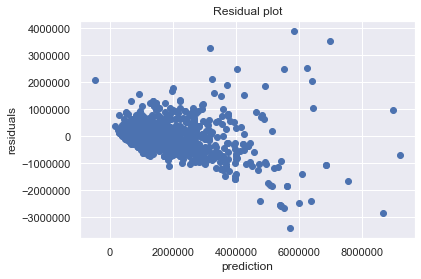

In [88]:
# Plot residuals
res = y_test - pred
plt.scatter(pred, res)
plt.title("Residual plot")
plt.xlabel("prediction")
plt.ylabel("residuals")

# res is NEGATIVE when prediction is LARGER than actual (over predicting)
# res is POSITIVE when prediction is SMALLER than actual (under predicting)

Text(0.5, 1.0, 'Normal Q-Q plot')

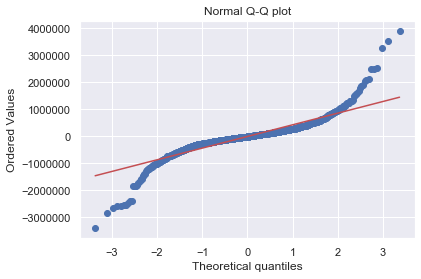

In [89]:
import scipy.stats as stats
# Plot Q-Q plot
#plt.subplot(1, 3, 3)
#Generates a probability plot of sample data against the quantiles of a 
# specified theoretical distribution 
stats.probplot(res, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")

# Has problems predicting really large and reall small values
# Comparing the residuals to a normal distribution
# This is HEAVY TAILED

In [ ]:
lm_reg = Ridge(alpha=1)
lm_reg.fit(X_tr, y_train)
pred = lm_reg.predict(X_te)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


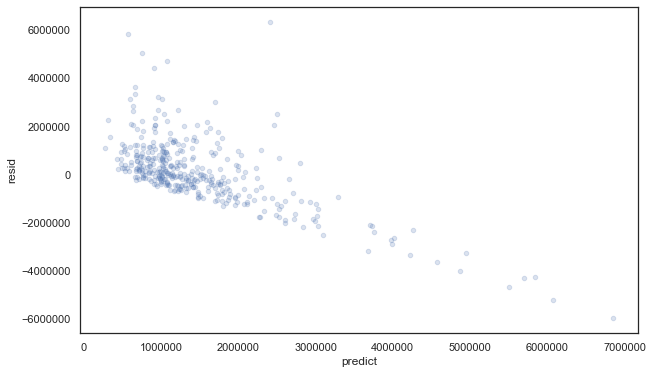

In [114]:
# Plot your predicted values on the x-axis, and your residuals on the y-axis
data = pd.DataFrame()
data['predict']= lm_reg.predict(X_te)
data['resid']= y_test - data['predict']
with sns.axes_style('white'):
    plot=data.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.2,figsize=(10,6))

# Heteroskedasticity is shown here. Residuals look like a "tornado"

In [ ]:
# Higher prediction, the more negative the residuals, meaning 
# the model is over predicting.

# Lower prediction, the more positive the residuals, meaning
# the model is under predicting.

In [124]:
# inspect histogram
#y_test[y_test < 10000000].hist(bins=25)
#plt.dist('Histogram of Dependent Variable (User Counts)');

#y_test[y_test < 10000000].hist(bins=25)
plt.dist(y_test[y_test < 10000000]);

AttributeError: module 'matplotlib.pyplot' has no attribute 'dist'

In [120]:
len(y[y < 10000000])

9190

In [121]:
len(y)

9213

In [129]:
X

,bldg_rating,apt_floor,square_feet,beds,baths,monthly_common_charges,monthly_real_estate_taxes,sold_season_Fall,sold_season_Spring,sold_season_Summer,sold_season_Winter,neighborhood_Beekman/Sutton Place,neighborhood_Midtown East,neighborhood_Midtown West,neighborhood_Murray Hill,neighborhood_Turtle Bay/United Nations,year_2004,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019
0,78.0,25.0,650.0,1.0,1.0,814.0,948.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,78.0,25.0,650.0,1.0,1.0,814.0,948.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,78.0,25.0,650.0,1.0,1.0,814.0,948.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,79.0,21.0,690.0,1.0,1.0,689.0,1315.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,79.0,21.0,690.0,1.0,1.0,689.0,1315.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9208,92.0,39.0,1431.0,2.0,2.5,1649.0,1786.0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9209,89.0,42.0,2062.0,2.0,3.0,2223.0,2514.0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9210,89.0,42.0,2062.0,2.0,3.0,2223.0,2514.0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9211,89.0,19.0,894.0,1.0,1.5,1045.0,833.0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [130]:
### Error Terms MUST have constant variance ###

import statsmodels.api as sm
import statsmodels.formula.api as smf

# look at numeric data
# X_tr, y_train
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sold_price   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     651.7
Date:                Thu, 10 Oct 2019   Prob (F-statistic):               0.00
Time:                        00:23:27   Log-Likelihood:            -1.3743e+05
No. Observations:                9213   AIC:                         2.749e+05
Df Residuals:                    9183   BIC:                         2.751e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
bldg_rating                             1.441e+04    797.487     18.064      0.000    1.28e+04     1.6e+04
apt_floor                                 28.0469     12.211      2.297      0.022       4.110      51.984
square_feet                             2870.1313     41.107     69.821      0.000    2789.552    2950.710
beds                                   -3.231e+05   1.88e+04    -17.156      0.000    -3.6e+05   -2.86e+05
baths                                  -7.898e+04   2.66e+04     -2.971      0.003   -1.31e+05   -2.69e+04
monthly_common_charges                   103.8350     14.958      6.942      0.000      74.514     133.156
monthly_real_estate_taxes                -33.1519     13.548     -2.447      0.014     -59.708      -6.595
sold_season_Fall                       -1.071e+06   3.56e+04    -30.119      0.000   -1.14e+06      -1e+06
sold_season_Spring                     -1.139e+06   3.54e+04    -32.162      0.000   -1.21e+06   -1.07e+06
sold_season_Summer                     -1.121e+06    3.5e+04    -31.998      0.000   -1.19e+06   -1.05e+06
sold_season_Winter                     -1.082e+06   3.59e+04    -30.133      0.000   -1.15e+06   -1.01e+06
neighborhood_Beekman/Sutton Place      -1.122e+06   4.72e+04    -23.756      0.000   -1.21e+06   -1.03e+06
neighborhood_Midtown East              -7.517e+05   3.42e+04    -22.001      0.000   -8.19e+05   -6.85e+05
neighborhood_Midtown West              -7.024e+05   2.94e+04    -23.864      0.000    -7.6e+05   -6.45e+05
neighborhood_Murray Hill               -9.291e+05   2.93e+04    -31.691      0.000   -9.87e+05   -8.72e+05
neighborhood_Turtle Bay/United Nations  -9.07e+05    3.3e+04    -27.489      0.000   -9.72e+05   -8.42e+05
year_2004                              -1.654e+06   3.47e+05     -4.773      0.000   -2.33e+06   -9.75e+05
year_2005                              -7.822e+05    2.2e+05     -3.560      0.000   -1.21e+06   -3.51e+05
year_2006                               -5.92e+05   2.31e+05     -2.558      0.011   -1.05e+06   -1.38e+05
year_2007                              -5.043e+05    1.5e+05     -3.359      0.001   -7.99e+05    -2.1e+05
year_2008                              -5.329e+05    1.2e+05     -4.430      0.000   -7.69e+05   -2.97e+05
year_2009                              -3.192e+05   5.51e+04     -5.791      0.000   -4.27e+05   -2.11e+05
year_2010                              -2.831e+05   4.42e+04     -6.399      0.000    -3.7e+05   -1.96e+05
year_2011                              -2.014e+05   4.18e+04     -4.812      0.000   -2.83e+05   -1.19e+05
year_2012                              -1.591e+05   3.91e+04     -4.070      0.000   -2.36e+05   -8.25e+04
year_2013                               -1.17e+05   3.74e+04     -3.125      0.002    -

In [128]:
7370-7083

287

# Investigating Target Variable

In [85]:
df_clean.head()

,full_name,bldg_name,bldg_addr,apt_floor,bldg_rating,sold_date,sold_date_dt,sold_price,price_per_sqft,square_feet,bed_and_bath,beds,baths,url,listed,days_on_market,neighborhood,monthly_common_charges,monthly_real_estate_taxes,minimum_down_payment,doorman,last_price_change,sold_season,days_on_market
0,"Worldwide Plaza, 393 West 49th Street, #3P",Worldwide Plaza,393 West 49th Street,3.0,73.0,"Last Sold on Sep 27, 2019",2019-09-27,545000.0,NaN,NaN,"Studio, 1 bath",0.0,1.0,https://www.cityrealty.com/nyc/midtown-west/wo...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,NaN
1,"The Cosmopolitan, 145 East 48th Street, #25G",The Cosmopolitan,145 East 48th Street,25.0,78.0,"Last Sold on Sep 25, 2019",2019-09-25,799000.0,1229.0,650.0,"1 bed, 1 bath",1.0,1.0,https://www.cityrealty.com/nyc/midtown-east/th...,2019-04-12,177,Midtown East,814.0,948.0,0.1,FT Doorman,NaN,Fall,166.0
2,"The Orion, 350 West 42nd Street, #21F",The Orion,350 West 42nd Street,21.0,79.0,"Last Sold on Sep 24, 2019",2019-09-24,1085000.0,1572.0,690.0,"1 bed, 1 bath",1.0,1.0,https://www.cityrealty.com/nyc/midtown-west/th...,2019-04-12,176,Midtown West,689.0,1315.0,NaN,FT Doorman,NaN,Fall,165.0
3,"Morgan Court, 211 Madison Avenue, #6A",Morgan Court,211 Madison Avenue,6.0,73.0,"Last Sold on Sep 23, 2019",2019-09-23,1039000.0,910.0,1142.0,"1 bed, 1.5 baths",1.0,1.5,https://www.cityrealty.com/nyc/murray-hill/mor...,2019-03-06,214,Murray Hill,1683.0,1148.0,NaN,FT Doorman,NaN,Fall,201.0
4,"325 Fifth Avenue, #23F",NaN,325 Fifth Avenue,23.0,70.0,"Last Sold on Sep 23, 2019",2019-09-23,1080000.0,1570.0,688.0,"1 bed, 1 bath",1.0,1.0,https://www.cityrealty.com/nyc/murray-hill/325...,2019-05-28,132,Murray Hill,810.0,1511.0,NaN,FT Doorman,NaN,Fall,118.0


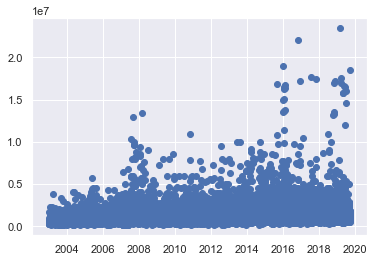

In [94]:
plt.scatter(df_clean['sold_date_dt'], df_clean['sold_price'])

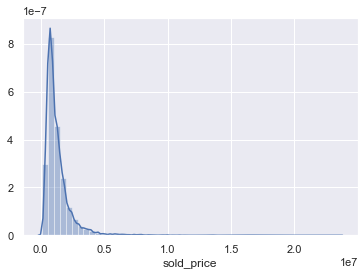

In [36]:
sns.distplot(df_clean['sold_price'])

In [99]:
len(df_clean) - len([df_clean['sold_price'] < 8000000])

14840

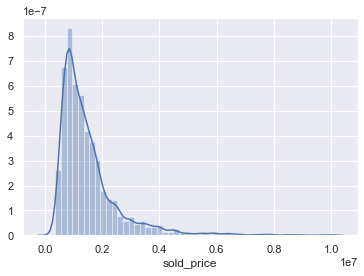

In [102]:
sns.distplot(df_model['sold_price'][df_model['sold_price'] < 10000000])